# EN3150 Assignment 3 - Complete Solution

## Waste Classification using Deep Learning

**Student Information:**
- Assignment: EN3150 Assignment 3 - Parts 1 & 2
- Dataset: RealWaste (9 classes)
- Framework: PyTorch

**Project Structure:**
- **Part 1 (Q1-Q12):** Custom DeepCNN trained from scratch
- **Part 2 (Q13-Q19):** Transfer Learning with Pre-trained Models

---

## Table of Contents

### Part 1: Custom CNN
1. [Setup & Data Loading](#setup)
2. [Model Architecture](#architecture)
3. [Training Functions](#training)
4. [Training with Multiple Optimizers](#optimizers)
5. [Evaluation & Visualization](#evaluation)
6. [Advanced Analysis](#analysis)

### Part 2: Transfer Learning
7. [Transfer Learning Setup](#transfer-setup)
8. [Pre-trained Models](#pretrained)
9. [Fine-tuning](#finetuning)
10. [Comparison & Discussion](#comparison)

---

# PART 1: CUSTOM CNN FROM SCRATCH

---

## 1. Setup & Data Loading <a id="setup"></a>

### Q1-Q2: Import libraries, configure environment, and load the RealWaste dataset

In [30]:
# Import required libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
import shutil
import glob
from IPython.display import clear_output

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("All libraries imported successfully.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

All libraries imported successfully.
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [31]:
# Define project constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 20  # Part 1: Train from scratch
EPOCHS_FT = 10  # Part 2: Fine-tuning
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SPLIT_DATA_DIR = 'data'

print("Configuration:")
print(f"   Device: {DEVICE}")
print(f"   Image Size: {IMAGE_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Classes: {NUM_CLASSES}")
print(f"   Epochs (Part 1): {EPOCHS}")
print(f"   Epochs (Part 2): {EPOCHS_FT}")

Configuration:
   Device: cuda
   Image Size: (224, 224)
   Batch Size: 32
   Classes: 9
   Epochs (Part 1): 20
   Epochs (Part 2): 10


In [32]:
# Define organized output paths
RESULTS_DIR = 'results'
MODELS_DIR = os.path.join(RESULTS_DIR, 'models')
VIZ_DIR = os.path.join(RESULTS_DIR, 'visualizations')
REPORTS_DIR = os.path.join(RESULTS_DIR, 'reports')
PART1_DIR = os.path.join(RESULTS_DIR, 'part1')
PART2_DIR = os.path.join(RESULTS_DIR, 'part2')

# Create directories if they don't exist
for directory in [RESULTS_DIR, MODELS_DIR, VIZ_DIR, REPORTS_DIR, PART1_DIR, PART2_DIR]:
    os.makedirs(directory, exist_ok=True)

print("Output directory structure created:")
print(f"   Models: {MODELS_DIR}")
print(f"   Visualizations: {VIZ_DIR}")
print(f"   Reports: {REPORTS_DIR}")
print(f"   Part 1 Results: {PART1_DIR}")
print(f"   Part 2 Results: {PART2_DIR}")

Output directory structure created:
   Models: results\models
   Visualizations: results\visualizations
   Reports: results\reports
   Part 1 Results: results\part1
   Part 2 Results: results\part2


In [33]:
def get_data_loaders():
    """Load pre-split RealWaste dataset with appropriate transforms."""
    
    # Training transforms with moderate augmentation
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Validation/Test transforms without augmentation
    val_test_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    train_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'train'),
        transform=train_transform
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'validation'),
        transform=val_test_transform
    )
    
    test_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'test'),
        transform=val_test_transform
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader, train_dataset.classes

# Load data
print("Loading RealWaste dataset...")
train_loader, val_loader, test_loader, class_names = get_data_loaders()

print("Data loaded successfully.")
print(f"   Training samples: {len(train_loader.dataset)}")
print(f"   Validation samples: {len(val_loader.dataset)}")
print(f"   Test samples: {len(test_loader.dataset)}")
print(f"   Classes ({NUM_CLASSES}): {class_names}")

Loading RealWaste dataset...
Data loaded successfully.
   Training samples: 4341
   Validation samples: 1319
   Test samples: 1338
   Classes (9): ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


## 2. Model Architecture <a id="architecture"></a>

### Q3-Q4: Implement Custom CNN Architecture

Architecture Details:
- Type: Sequential CNN with 4 convolutional blocks
- Convolutional Layers: 4 layers (32 → 64 → 128 → 256 channels)
- Normalization: Batch Normalization after each conv layer
- Pooling: MaxPooling after each conv layer
- Fully Connected: 3 FC layers (512 → 256 → 9)
- Regularization: Dropout (0.5, 0.3)
- Parameters: ~8.5 million

This architecture provides a good balance between capacity and training efficiency.

In [ ]:
class WasteCustom(nn.Module):
    """Custom CNN with 4 convolutional blocks and 3 FC layers."""
    def __init__(self, num_classes=9):
        super(WasteCustom, self).__init__()
        
        # Convolutional Block 1: 3 -> 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 4: 128 -> 256
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        # Adaptive pooling to ensure consistent size (256 x 8 x 8 = 16384)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        self.fc1 = nn.Linear(in_features=16384, out_features=512, bias=True)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(p=0.5, inplace=False)
        
        self.fc2 = nn.Linear(in_features=512, out_features=256, bias=True)
        self.dropout2 = nn.Dropout(p=0.3, inplace=False)
        
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes, bias=True)
        
        # Activation
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Convolutional Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Convolutional Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Convolutional Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        # Convolutional Block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool4(x)
        
        # Adaptive pooling to ensure consistent size
        x = self.adaptive_pool(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Fully Connected Layer 1
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Fully Connected Layer 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Output Layer
        x = self.fc3(x)
        
        return x

# Create and display model
model = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("WasteCustom model created.")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print("Architecture: 4 Conv blocks (32→64→128→256) + 3 FC layers (512→256→9)")
print("Features: BatchNorm + Dropout regularization")
print("\nModel Architecture:")
print(model)

✅ DeepCNN Model Created!
   Total Parameters: 8,913,161
   Trainable Parameters: 8,913,161
   Architecture: 4 Conv blocks (32→64→128→256) + 3 FC layers (512→256→9)
   Features: BatchNorm + Dropout regularization

📐 Model Architecture:
DeepCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

## 3. Training Functions <a id="training"></a>

### Q5-Q6: Implement training loop with advanced features

**Features:**
- ✅ Batch-level progress tracking with running averages
- ✅ Gradient norm monitoring
- ✅ GPU memory tracking
- ✅ Real-time visualization
- ✅ **Learning Rate Scheduling** (CosineAnnealingWarmRestarts)
- ✅ Trend indicators (📈/📉)
- ✅ ETA calculation

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch with detailed progress tracking."""
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    
    # For running averages
    batch_losses = []
    batch_accs = []
    
    total_batches = len(dataloader)
    
    for batch_idx, (inputs, labels) in enumerate(dataloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Calculate gradient norm
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        optimizer.step()
        
        # Statistics
        batch_loss = loss.item()
        _, preds = torch.max(outputs, 1)
        batch_correct = (preds == labels).sum().item()
        batch_acc = batch_correct / inputs.size(0)
        
        running_loss += batch_loss * inputs.size(0)
        running_correct += batch_correct
        total_samples += inputs.size(0)
        
        batch_losses.append(batch_loss)
        batch_accs.append(batch_acc)
        
        # Calculate running averages
        avg_loss = running_loss / total_samples
        avg_acc = running_correct / total_samples
        
        # Progress bar
        progress = batch_idx / total_batches
        bar_length = 20
        filled = int(bar_length * progress)
        bar = '█' * filled + '░' * (bar_length - filled)
        
        # Print detailed progress (every 10 batches or last batch)
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"   Batch [{batch_idx:3d}/{total_batches}] |{bar}| {progress*100:5.1f}% | "
                  f"Loss: {batch_loss:.4f} | Acc: {batch_acc:.4f} | "
                  f"Avg Loss: {avg_loss:.4f} | Avg Acc: {avg_acc:.4f} | "
                  f"Grad: {total_norm:.3f}", end='\r')
    
    print()  # New line after progress
    epoch_loss = running_loss / total_samples
    epoch_acc = running_correct / total_samples
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    
    total_batches = len(dataloader)
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader, 1):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total_samples += inputs.size(0)
            
            # Simple progress indicator
            if batch_idx % 10 == 0 or batch_idx == total_batches:
                progress = batch_idx / total_batches
                print(f"   Validating... {progress*100:.0f}%", end='\r')
    
    print()  # New line
    epoch_loss = running_loss / total_samples
    epoch_acc = running_correct / total_samples
    
    return epoch_loss, epoch_acc

print("✅ Training functions defined!")

✅ Training functions defined!


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device, model_name, use_scheduler=True):
    """Complete training loop with detailed visualization, progress tracking, and learning rate scheduling."""
    
    print("\n" + "="*80)
    print(f"TRAINING {model_name}")
    print("="*80)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'learning_rates': []}
    best_val_acc = 0.0
    start_time = time.time()
    
    # Initialize learning rate scheduler - CosineAnnealingWarmRestarts
    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=10,        # Restart every 10 epochs
            T_mult=1,     
            eta_min=1e-6  # Minimum learning rate
        )
        print("Learning Rate Scheduler: CosineAnnealingWarmRestarts")
        print("   T_0: 10 epochs | T_mult: 1 | Min LR: 1e-6")
    
    # Setup for live plotting
    plt.ion()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        
        # Training phase
        print(f"\n{'-'*50}")
        print(f"Training Phase (LR: {current_lr:.6f})")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        print("Validation Phase:")
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Learning rate scheduling - step after each epoch
        if scheduler is not None:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step()
            new_lr = optimizer.param_groups[0]['lr']
            
            # Report significant LR changes
            if abs(new_lr - old_lr) > 1e-7:
                change = "restart" if new_lr > old_lr else "decay"
                print(f"Learning Rate {change}: {old_lr:.6f} -> {new_lr:.6f}")
        
        # Determine trends
        train_trend = ""
        val_trend = ""
        if epoch > 0:
            train_trend = " down" if train_loss < history['train_loss'][epoch-1] else " up"
            if val_acc > history['val_acc'][epoch-1]:
                val_trend = " up"
            elif val_acc < history['val_acc'][epoch-1]:
                val_trend = " down"
        
        # Save best model
        best_marker = ""
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = os.path.join(MODELS_DIR, f'best_model_{model_name}.pth')
            torch.save(model.state_dict(), save_path)
            best_marker = " (new best)"
        
        epoch_time = time.time() - epoch_start
        total_time = time.time() - start_time
        eta = (total_time / (epoch + 1)) * (epochs - epoch - 1)
        
        # GPU memory info
        gpu_info = ""
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / 1024**2
            reserved = torch.cuda.memory_reserved(device) / 1024**2
            gpu_info = f"GPU memory -> Allocated: {allocated:.1f}MB | Reserved: {reserved:.1f}MB"
        
        # Print epoch summary
        print(f"{'-'*50}")
        print(f"EPOCH [{epoch+1}/{epochs}] SUMMARY:")
        print(f"   LR: {current_lr:.6f}")
        print(f"   Train -> Loss: {train_loss:.4f}{train_trend} | Acc: {train_acc:.4f} ({train_acc*100:.1f}%)")
        print(f"   Val   -> Loss: {val_loss:.4f} | Acc: {val_acc:.4f} ({val_acc*100:.1f}%) {val_trend}{best_marker}")
        print(f"   Time -> Epoch: {epoch_time:.1f}s | Total: {total_time:.1f}s | ETA: {eta:.1f}s")
        if gpu_info:
            print(gpu_info)
        print(f"{'-'*50}")
        
        # Real-time visualization
        if epoch % 1 == 0 or epoch == epochs - 1:
            epochs_range = range(1, len(history['train_loss']) + 1)
            
            for ax in axes:
                ax.clear()
            
            # Plot Loss
            axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
            axes[0].plot(epochs_range, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
            axes[0].set_title(f'{model_name} - Loss Progress', fontsize=12, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot Accuracy
            axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
            axes[1].plot(epochs_range, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)
            axes[1].set_title(f'{model_name} - Accuracy Progress', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            axes[1].set_ylim([0, 1])
            
            # Annotations
            axes[0].text(0.02, 0.98, f'Current: Train={train_loss:.4f}, Val={val_loss:.4f}',
                        transform=axes[0].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            axes[1].text(0.02, 0.98, f'Current: Train={train_acc:.4f}, Val={val_acc:.4f}\nBest Val: {best_val_acc:.4f}\nLR: {current_lr:.6f}',
                        transform=axes[1].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
            
            plt.tight_layout()
            plt.pause(0.01)
            clear_output(wait=True)
            plt.show()
            
            # Reprint summary
            print(f"\n{'-'*50}")
            print(f"EPOCH [{epoch+1}/{epochs}] SUMMARY:")
            print(f"   LR: {current_lr:.6f}")
            print(f"   Train -> Loss: {train_loss:.4f}{train_trend} | Acc: {train_acc:.4f} ({train_acc*100:.1f}%)")
            print(f"   Val   -> Loss: {val_loss:.4f} | Acc: {val_acc:.4f} ({val_acc*100:.1f}%) {val_trend}{best_marker}")
            print(f"   Time -> Epoch: {epoch_time:.1f}s | Total: {total_time:.1f}s | ETA: {eta:.1f}s")
            if gpu_info:
                print(gpu_info)
            print(f"{'-'*50}")
    
    plt.ioff()
    plt.close(fig)
    
    total_time = time.time() - start_time
    print("\n" + "="*80)
    print(f"TRAINING COMPLETE - {model_name}")
    print("="*80)
    print(f"   Total Time: {total_time/60:.1f} min ({total_time:.1f}s)")
    print(f"   Best Val Acc: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"   Final LR: {history['learning_rates'][-1]:.6f}")
    print(f"   Model saved: {MODELS_DIR}/best_model_{model_name}.pth")
    print("="*80)
    
    return history, best_val_acc

print("Complete training function with CosineAnnealingWarmRestarts scheduling defined.")

✅ Complete training function with CosineAnnealingWarmRestarts scheduling defined!


## 4. Training with Multiple Optimizers <a id="optimizers"></a>

### Q5-Q6: Train the custom CNN with Adam, SGD, and SGD+Momentum

We'll train the model three times with different optimizers to compare their effectiveness.

In [ ]:
# Create fresh model instance for Adam
model_adam = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Train with Adam
adam_history, adam_best_acc = train_model(
    model=model_adam,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_adam,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_Adam',
    use_scheduler=True
)


──────────────────────────────────────────────────
📊 EPOCH [20/20] SUMMARY:
   📚 LR    → 0.000025
   🏃 Train → Loss: 0.4808 📉 | Acc: 0.8279 (82.8%)
   🎯 Val   → Loss: 0.3404 | Acc: 0.8817 (88.2%) 📉
   ⏱️  Time  → Epoch: 40.6s | Total: 779.6s | ETA: 0.0s
   💾 GPU   → Allocated: 255.3MB | Reserved: 1946.0MB
──────────────────────────────────────────────────

🎉 TRAINING COMPLETE - DEEPCNN_ADAM
   ⏱️  Total Time: 13.0 min (779.6s)
   🏆 Best Val Acc: 0.8825 (88.25%)
   📚 Final LR: 0.000025
   💾 Model saved: results\models/best_model_DeepCNN_Adam.pth



📊 ADAM TRAINING VISUALIZATION
✅ Adam training visualization saved to: results\part1\adam_training_analysis.png
✅ Adam training visualization saved to: results\part1\adam_training_analysis.png


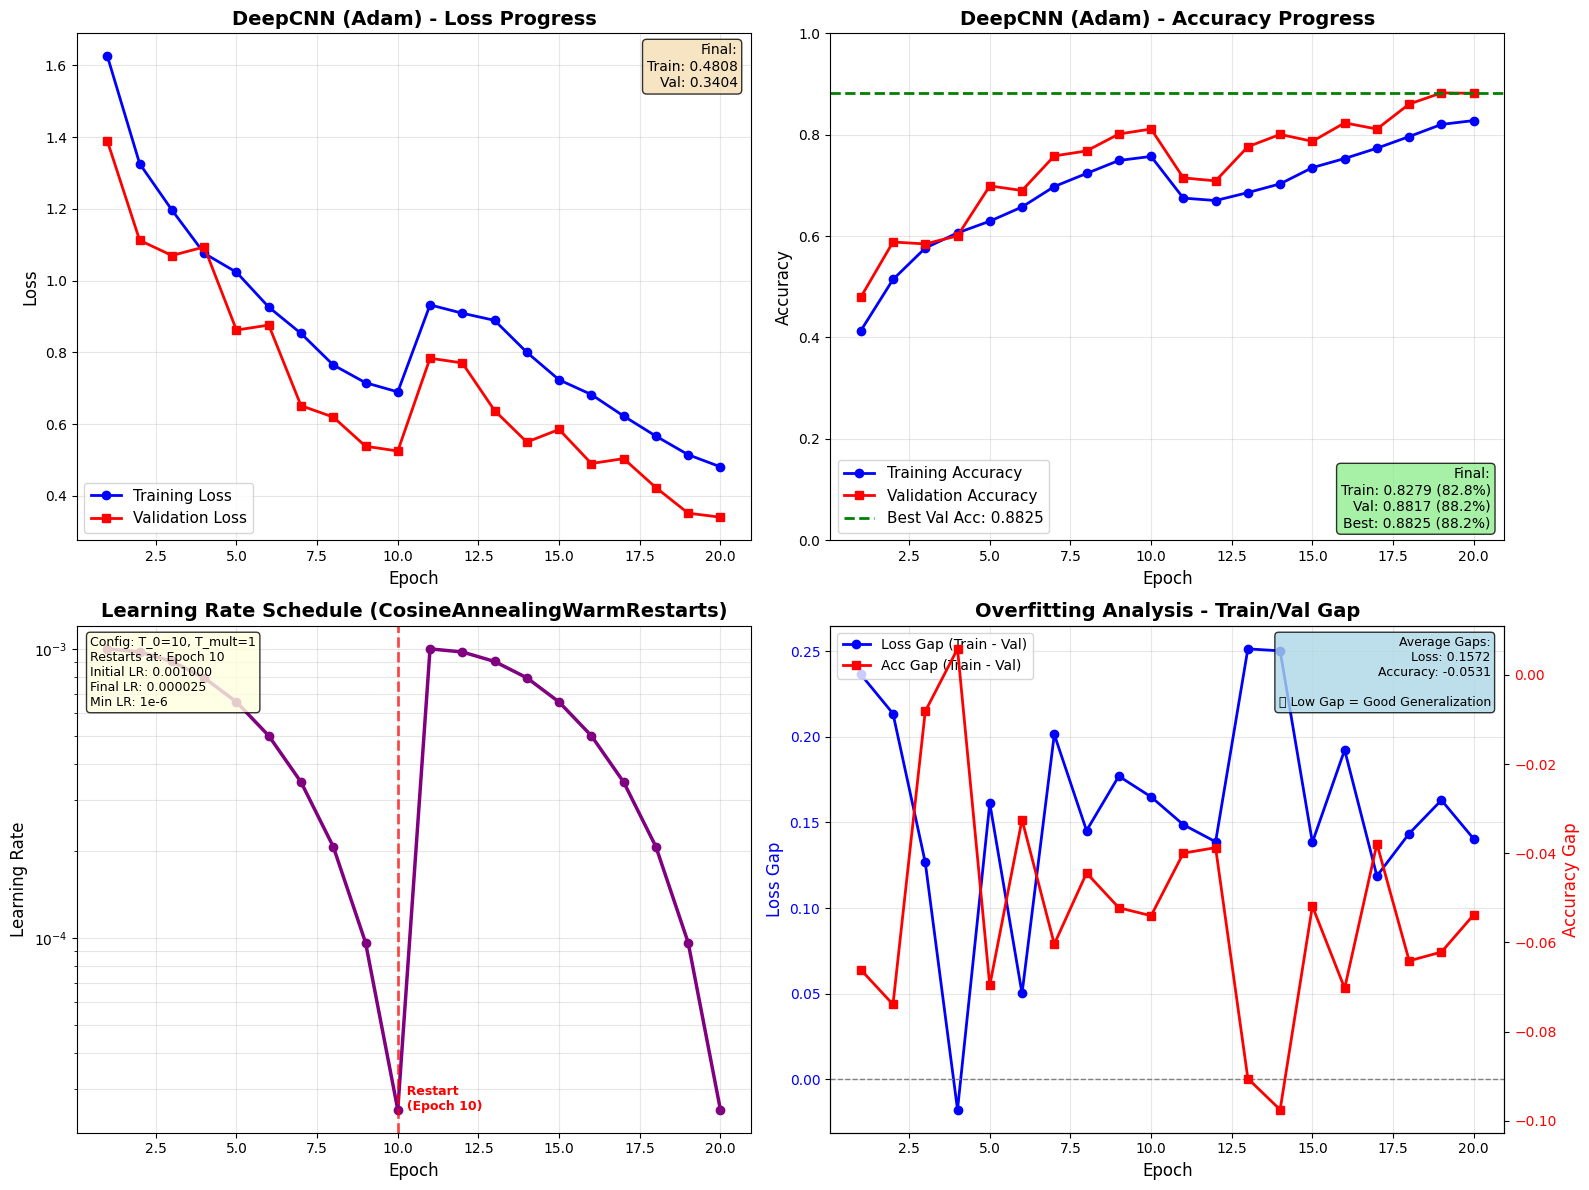


📈 ADAM TRAINING SUMMARY STATISTICS

🎯 Final Performance:
   • Training Loss:      0.4808
   • Training Accuracy:  0.8279 (82.79%)
   • Validation Loss:    0.3404
   • Validation Accuracy: 0.8817 (88.17%)
   • Best Val Accuracy:  0.8825 (88.25%) ⭐

📊 Training Progress:
   • Loss Improvement:   1.6253 → 0.4808 (1.1445 decrease)
   • Accuracy Gain:      0.4130 → 0.8279 (0.4149 increase)

🔍 Generalization Analysis:
   • Final Loss Gap:     0.1404 (lower is better)
   • Final Accuracy Gap: -0.0538 (lower is better)
   • Avg Loss Gap:       0.1572
   • Avg Accuracy Gap:   -0.0531
   • Status: ✅ Good generalization

📚 Learning Rate:
   • Initial LR:  0.001000
   • Final LR:    0.000025
   • Min LR:      1.000000e-06
   • Restarts:    Epoch 10 (T_0=10, T_mult=1)

💡 Key Observations:
   • Best model achieved at epoch 19
   • Model trained for 20 epochs
   • Scheduler completed 2 full cycles (epochs 1-10, 11-20)
   • Total parameters: 8,913,161


In [ ]:
# Visualize Adam training results
print("\n" + "="*80)
print("ADAM TRAINING VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_range = range(1, len(adam_history['train_loss']) + 1)

# Plot 1: Training & Validation Loss
axes[0, 0].plot(epochs_range, adam_history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0, 0].plot(epochs_range, adam_history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
axes[0, 0].set_title('WasteCustom (Adam) - Loss Progress', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Add final values annotation
final_train_loss = adam_history['train_loss'][-1]
final_val_loss = adam_history['val_loss'][-1]
axes[0, 0].text(0.98, 0.98, f'Final:\nTrain: {final_train_loss:.4f}\nVal: {final_val_loss:.4f}',
                transform=axes[0, 0].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Training & Validation Accuracy
axes[0, 1].plot(epochs_range, adam_history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
axes[0, 1].plot(epochs_range, adam_history['val_acc'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
axes[0, 1].axhline(y=adam_best_acc, color='g', linestyle='--', linewidth=2, label=f'Best Val Acc: {adam_best_acc:.4f}')
axes[0, 1].set_title('WasteCustom (Adam) - Accuracy Progress', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Add final values annotation
final_train_acc = adam_history['train_acc'][-1]
final_val_acc = adam_history['val_acc'][-1]
axes[0, 1].text(0.98, 0.02, f'Final:\nTrain: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)\nVal: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)\nBest: {adam_best_acc:.4f} ({adam_best_acc*100:.1f}%)',
                transform=axes[0, 1].transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Plot 3: Learning Rate Schedule
axes[1, 0].plot(epochs_range, adam_history['learning_rates'], 'purple', linewidth=2.5, marker='o', markersize=6)
axes[1, 0].set_title('Learning Rate Schedule (CosineAnnealingWarmRestarts)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3, which='both')

# Highlight restart points (T_0=10, T_mult=1 -> restarts at epoch 10)
restart_epochs = [10]
for restart_epoch in restart_epochs:
    if restart_epoch <= len(adam_history['learning_rates']):
        axes[1, 0].axvline(x=restart_epoch, color='red', linestyle='--', linewidth=2, alpha=0.7)
        axes[1, 0].text(restart_epoch, adam_history['learning_rates'][restart_epoch-1], 
                       f'  Restart\n  (Epoch {restart_epoch})', fontsize=9, color='red', fontweight='bold')

# Add annotation
axes[1, 0].text(0.02, 0.98, f'Config: T_0=10, T_mult=1\nRestarts at: Epoch 10\nInitial LR: {adam_history["learning_rates"][0]:.6f}\nFinal LR: {adam_history["learning_rates"][-1]:.6f}\nMin LR: 1e-6',
                transform=axes[1, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# Plot 4: Overfitting Analysis (Train vs Val Gap)
loss_gap = [train - val for train, val in zip(adam_history['train_loss'], adam_history['val_loss'])]
acc_gap = [train - val for train, val in zip(adam_history['train_acc'], adam_history['val_acc'])]

ax4_1 = axes[1, 1]
ax4_2 = ax4_1.twinx()

line1 = ax4_1.plot(epochs_range, loss_gap, 'b-o', label='Loss Gap (Train - Val)', linewidth=2, markersize=6)
line2 = ax4_2.plot(epochs_range, acc_gap, 'r-s', label='Acc Gap (Train - Val)', linewidth=2, markersize=6)

ax4_1.set_title('Overfitting Analysis - Train/Val Gap', fontsize=14, fontweight='bold')
ax4_1.set_xlabel('Epoch', fontsize=12)
ax4_1.set_ylabel('Loss Gap', fontsize=12, color='b')
ax4_2.set_ylabel('Accuracy Gap', fontsize=12, color='r')
ax4_1.tick_params(axis='y', labelcolor='b')
ax4_2.tick_params(axis='y', labelcolor='r')
ax4_1.grid(True, alpha=0.3)
ax4_1.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4_1.legend(lines, labels, loc='upper left', fontsize=10)

# Add interpretation
avg_loss_gap = np.mean(loss_gap)
avg_acc_gap = np.mean(acc_gap)
axes[1, 1].text(0.98, 0.98, f'Average Gaps:\nLoss: {avg_loss_gap:.4f}\nAccuracy: {avg_acc_gap:.4f}',
                transform=axes[1, 1].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
save_path = os.path.join(PART1_DIR, 'adam_training_analysis.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Adam training visualization saved to: {save_path}")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("ADAM TRAINING SUMMARY STATISTICS")
print("="*80)
print("Final Performance:")
print(f"   Training Loss:      {final_train_loss:.4f}")
print(f"   Training Accuracy:  {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   Validation Loss:    {final_val_loss:.4f}")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   Best Val Accuracy:  {adam_best_acc:.4f} ({adam_best_acc*100:.2f}%)")

print("Training Progress:")
print(f"   Loss Improvement:   {adam_history['train_loss'][0]:.4f} -> {final_train_loss:.4f} ({(adam_history['train_loss'][0] - final_train_loss):.4f} decrease)")
print(f"   Accuracy Gain:      {adam_history['train_acc'][0]:.4f} -> {final_train_acc:.4f} ({(final_train_acc - adam_history['train_acc'][0]):.4f} increase)")

print("Generalization Analysis:")
print(f"   Final Loss Gap:     {final_train_loss - final_val_loss:.4f} (lower is better)")
print(f"   Final Accuracy Gap: {final_train_acc - final_val_acc:.4f} (lower is better)")
print(f"   Avg Loss Gap:       {avg_loss_gap:.4f}")
print(f"   Avg Accuracy Gap:   {avg_acc_gap:.4f}")

print("Learning Rate:")
print(f"   Initial LR:  {adam_history['learning_rates'][0]:.6f}")
print(f"   Final LR:    {adam_history['learning_rates'][-1]:.6f}")
print("   Min LR:      1.000000e-06")
print("   Restarts:    Epoch 10 (T_0=10, T_mult=1)")

best_epoch = adam_history['val_acc'].index(adam_best_acc) + 1
print(f"Best model achieved at epoch {best_epoch}")
print(f"Model trained for {EPOCHS} epochs")
print(f"Total parameters: {sum(p.numel() for p in model_adam.parameters()):,}")
print("="*80)

In [ ]:
# Create fresh model instance for SGD
model_sgd = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Train with SGD
sgd_history, sgd_best_acc = train_model(
    model=model_sgd,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_sgd,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_SGD',
    use_scheduler=True
)


──────────────────────────────────────────────────
📊 EPOCH [20/20] SUMMARY:
   📚 LR    → 0.000246
   🏃 Train → Loss: 0.6135 📉 | Acc: 0.7941 (79.4%)
   🎯 Val   → Loss: 0.4495 | Acc: 0.8431 (84.3%) 📉
   ⏱️  Time  → Epoch: 36.3s | Total: 847.9s | ETA: 0.0s
   💾 GPU   → Allocated: 323.8MB | Reserved: 1946.0MB
──────────────────────────────────────────────────

🎉 TRAINING COMPLETE - DEEPCNN_SGD
   ⏱️  Total Time: 14.1 min (848.0s)
   🏆 Best Val Acc: 0.8446 (84.46%)
   📚 Final LR: 0.000246
   💾 Model saved: results\models/best_model_DeepCNN_SGD.pth


In [ ]:
# Create fresh model instance for SGD+Momentum
model_sgd_momentum = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_sgd_momentum = optim.SGD(model_sgd_momentum.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Train with SGD+Momentum
sgd_momentum_history, sgd_momentum_best_acc = train_model(
    model=model_sgd_momentum,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_sgd_momentum,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_SGD_Momentum',
    use_scheduler=True
)


──────────────────────────────────────────────────
📊 EPOCH [20/20] SUMMARY:
   📚 LR    → 0.000246
   🏃 Train → Loss: 0.5754 📉 | Acc: 0.7973 (79.7%)
   🎯 Val   → Loss: 0.4032 | Acc: 0.8628 (86.3%) 📈 ⭐ NEW BEST!
   ⏱️  Time  → Epoch: 37.0s | Total: 845.8s | ETA: 0.0s
   💾 GPU   → Allocated: 426.5MB | Reserved: 1950.0MB
──────────────────────────────────────────────────

🎉 TRAINING COMPLETE - DEEPCNN_SGD_MOMENTUM
   ⏱️  Total Time: 14.1 min (845.8s)
   🏆 Best Val Acc: 0.8628 (86.28%)
   📚 Final LR: 0.000246
   💾 Model saved: results\models/best_model_DeepCNN_SGD_Momentum.pth


## 5. Evaluation & Visualization <a id="evaluation"></a>

### Q7-Q9: Evaluate models and create visualizations

✅ Plot saved to results\part1\optimizer_comparison.png


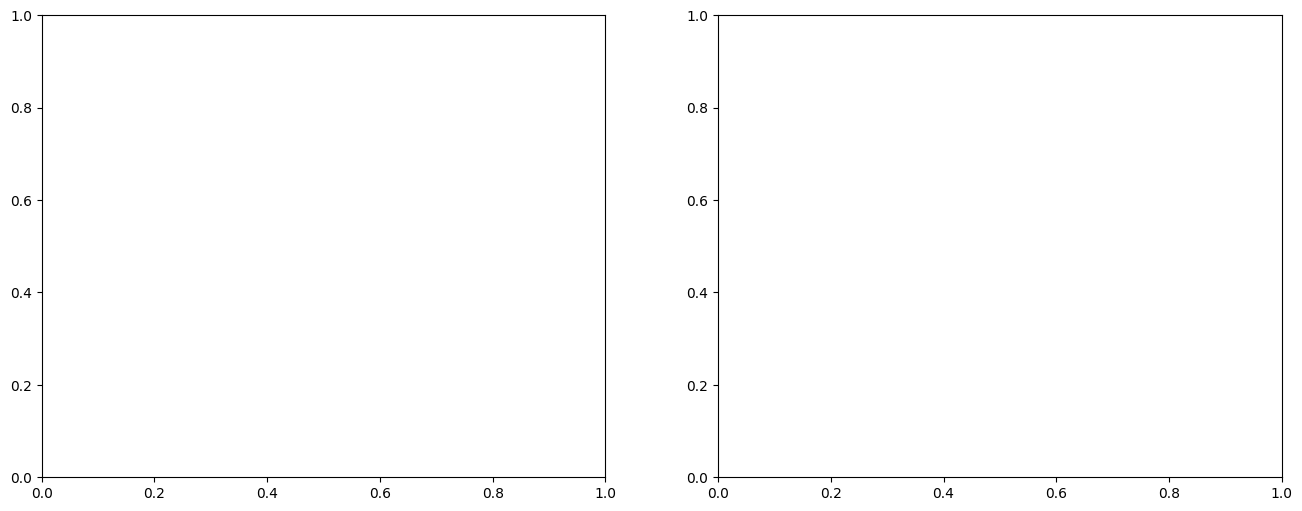

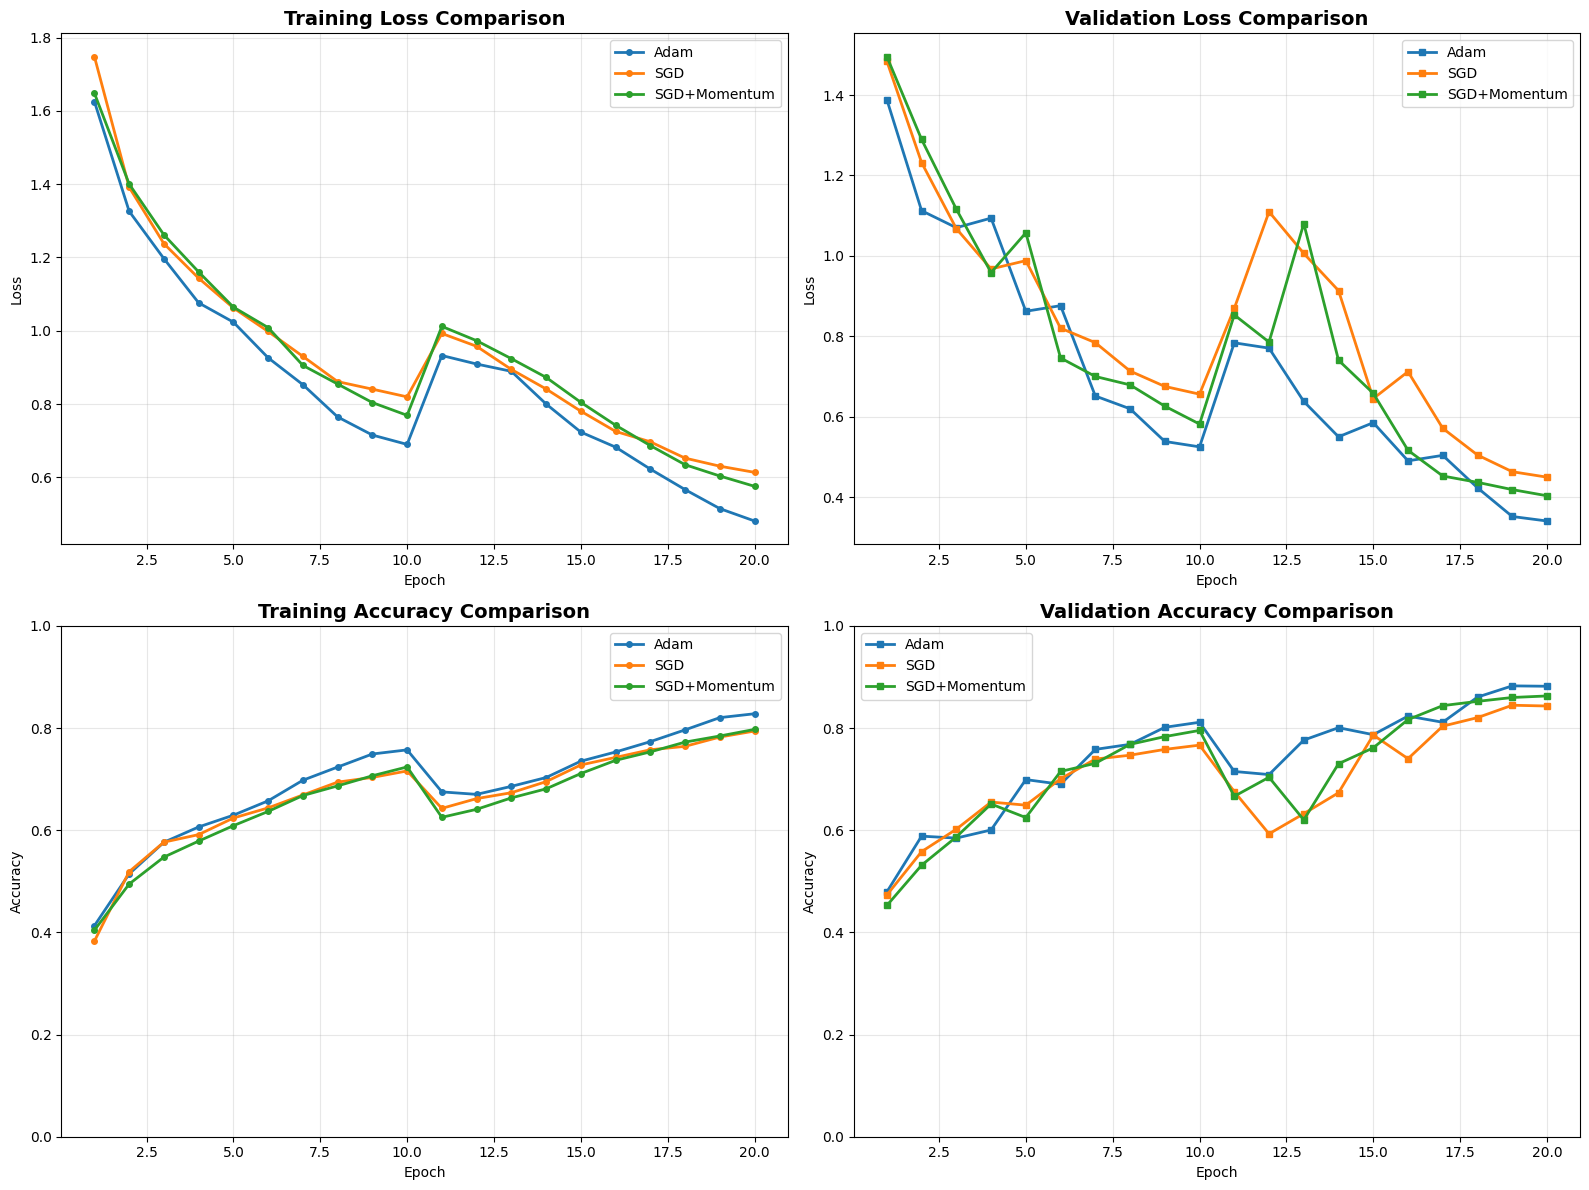

In [ ]:
def plot_optimizer_comparison(histories, names, save_path=None):
    """Compare training progress across different optimizers."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    epochs = range(1, len(histories[0]['train_loss']) + 1)
    
    # Loss comparison
    for history, name in zip(histories, names):
        axes[0, 0].plot(epochs, history['train_loss'], '-o', label=f'{name}', linewidth=2, markersize=4)
    axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Validation Loss comparison
    for history, name in zip(histories, names):
        axes[0, 1].plot(epochs, history['val_loss'], '-s', label=f'{name}', linewidth=2, markersize=4)
    axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training Accuracy comparison
    for history, name in zip(histories, names):
        axes[1, 0].plot(epochs, history['train_acc'], '-o', label=f'{name}', linewidth=2, markersize=4)
    axes[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])
    
    # Validation Accuracy comparison
    for history, name in zip(histories, names):
        axes[1, 1].plot(epochs, history['val_acc'], '-s', label=f'{name}', linewidth=2, markersize=4)
    axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    plt.show()

# Compare all optimizers
plot_optimizer_comparison(
    histories=[adam_history, sgd_history, sgd_momentum_history],
    names=['Adam', 'SGD', 'SGD+Momentum'],
    save_path=os.path.join(PART1_DIR, 'optimizer_comparison.png')
)